# Data Warehousing - [AWS Redshift + Python]

## Infra-as-Code :: Python with AWS (boto3 SDK)

In [129]:
import boto3
import pandas as pd
import psycopg2
import json
from IPython.display import Image, display

### Reading config file that has AWS keys & warehouse details -

In [67]:
import configparser
config = configparser.ConfigParser()
config.read_file(open('cluster.config'))

In [17]:
# config.get("AWS","KEY")

In [68]:
KEY=config.get("AWS","KEY")
SECRET=config.get("AWS","SECRET")

DWH_CLUSTER_TYPE=config.get("DWH","DWH_CLUSTER_TYPE")
DWH_NUM_NODES=config.get("DWH","DWH_NUM_NODES")
DWH_NODE_TYPE=config.get("DWH","DWH_NODE_TYPE")
DWH_CLUSTER_IDENTIFIER=config.get("DWH","DWH_CLUSTER_IDENTIFIER")
DWH_DB=config.get("DWH","DWH_DB")
DWH_DB_USER=config.get("DWH","DWH_DB_USER")
DWH_DB_PASSWORD=config.get("DWH","DWH_DB_PASSWORD")
DWH_PORT=config.get("DWH","DWH_PORT")
DWH_IAM_ROLE_NAME=config.get("DWH","DWH_IAM_ROLE_NAME")

## Objects for EC2, S3, IAM and Redshift -

In [69]:
import boto3
ec2 = boto3.resource('ec2', region_name = 'us-east-2',
                     aws_access_key_id = KEY,
                     aws_secret_access_key = SECRET)
s3 = boto3.resource('s3',region_name = 'us-east-2',
                     aws_access_key_id = KEY,
                     aws_secret_access_key = SECRET)
iam = boto3.client('iam', region_name = 'us-east-2',
                     aws_access_key_id = KEY,
                     aws_secret_access_key = SECRET)
redshift = boto3.client('redshift', region_name = 'us-east-2',
                     aws_access_key_id = KEY,
                     aws_secret_access_key = SECRET)

## S3 Bucket objects -

['allevents_pipe.txt', 'allusers_pipe.txt', 'category_pipe.txt', 'date2008_pipe.txt', 'listings_pipe.txt', 'sales_tab.txt', 'venue_pipe.txt']


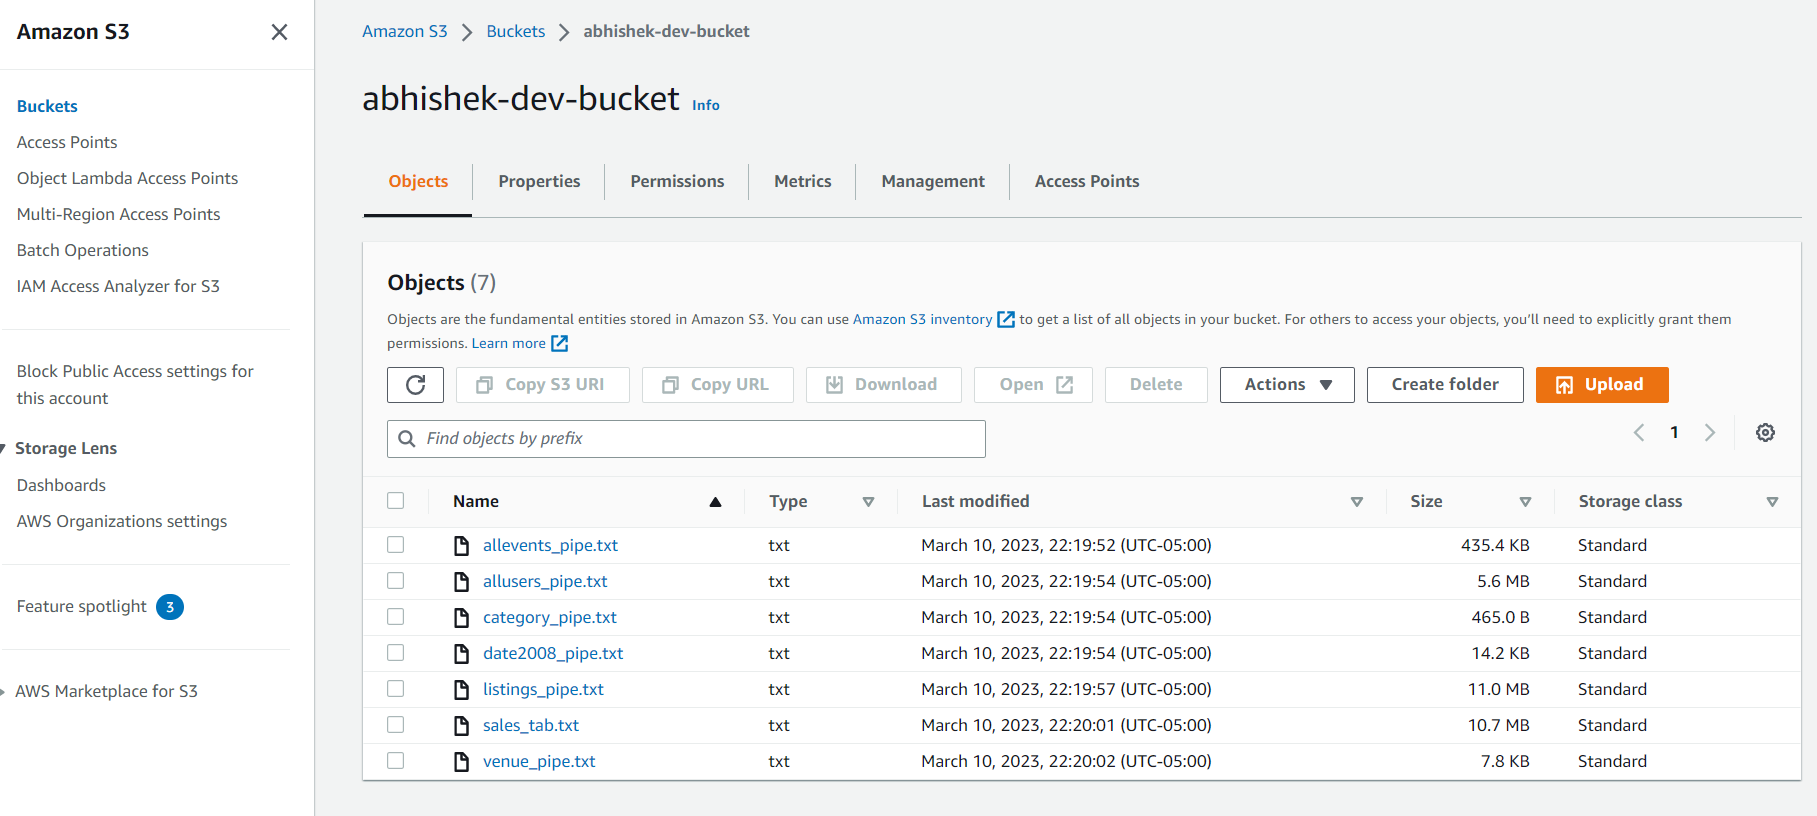

In [137]:
my_bucket = s3.Bucket('abhishek-dev-bucket') # using tickitdb dataset from AWS
log_files = [file.key for file in my_bucket.objects.filter(Prefix='')] # Prefix='' gives list of all files in the bucket
print(log_files)
display(Image(filename='images/s3.png'))

## IAM Role -
To connect S3 with Redshift, we'll use our IAM role.
(The IAM role for Redshift service is already created on AWS with the S3fullaccess policy)

### ARN -
ARNs (Amazon Resource Names) uniquely identify AWS resources. We require an ARN when you need to specify a resource unambiguously across all of AWS, such as in IAM policies, Amazon Relational Database Service (Amazon RDS) tags, and API calls.

In [71]:
role_arn = iam.get_role(RoleName= DWH_IAM_ROLE_NAME)['Role']['Arn']

## Redshift cluster -

### Creating Redshift cluster using Python -

In [102]:
try:
    response = redshift.create_cluster(        
        ClusterType = DWH_CLUSTER_TYPE,
        NodeType = DWH_NODE_TYPE,
        NumberOfNodes = int(DWH_NUM_NODES),
        DBName= DWH_DB,
        ClusterIdentifier = DWH_CLUSTER_IDENTIFIER,
        MasterUsername= DWH_DB_USER,
        MasterUserPassword = DWH_DB_PASSWORD,
        # S3 access
        IamRoles=[role_arn]
    )
except Exception as e:
    print(e)

In [101]:
# To view all info of the cluster -
# redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]

In [103]:
# To view Cluster Properties - 
myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]

###  Creating a TCP port to access cluster endpoint -

In [141]:
try:
    vpc = ec2.Vpc(id=myClusterProps['VpcId'])
    defaultSg = list(vpc.security_groups.all())[0]
    
    defaultSg.authorize_ingress(
        GroupName= defaultSg.group_name,
        CidrIp='0.0.0.0/0',
        IpProtocol='TCP',
        FromPort=int(DWH_PORT),
        ToPort=int(DWH_PORT)
    )
except Exception as e:
    print(e)

An error occurred (InvalidPermission.Duplicate) when calling the AuthorizeSecurityGroupIngress operation: the specified rule "peer: 0.0.0.0/0, TCP, from port: 5439, to port: 5439, ALLOW" already exists


In [105]:
DWH_ENDPOINT = myClusterProps['Endpoint']['Address']
DWH_ROLE_ARN = myClusterProps['IamRoles'][0]['IamRoleArn']
DB_NAME = myClusterProps['DBName']
DB_USER = myClusterProps['MasterUsername']

### Creating database connector using psycopg2 -

(psycopg is a PostgreSQL database adapter for Python)

In [108]:
conn = psycopg2.connect(host=DWH_ENDPOINT, dbname=DB_NAME, user=DB_USER, password=DWH_DB_PASSWORD, port=DWH_PORT) 

In [109]:
conn.set_session(autocommit=True) 

In [110]:
cur = conn.cursor()

## Creating Tables for OLAP -

We can optimize the warehousing process using DISTKEY & SORTKEY as done below -

In [111]:
try:
    cur.execute("""create table users(
	userid integer not null distkey sortkey,
	username char(8),
	firstname varchar(30),
	lastname varchar(30),
	city varchar(30),
	state char(2),
	email varchar(100),
	phone char(14),
	likesports boolean,
	liketheatre boolean,
	likeconcerts boolean,
	likejazz boolean,
	likeclassical boolean,
	likeopera boolean,
	likerock boolean,
	likevegas boolean,
	likebroadway boolean,
	likemusicals boolean);
    """)
except psycopg2.Error as e:
    print(e)

In [112]:
try:
    cur.execute("""create table venue(
    venueid smallint not null distkey sortkey,
    venuename varchar(100),
    venuecity varchar(30),
    venuestate char(2),
    venueseats integer);
    """)
except psycopg2.Error as e:
    print(e)

In [113]:
try:
    cur.execute("""create table category(
    catid smallint not null distkey sortkey,
	catgroup varchar(10),
	catname varchar(10),
	catdesc varchar(50));
    
    create table date(
	dateid smallint not null distkey sortkey,
	caldate date not null,
	day character(3) not null,
	week smallint not null,
	month character(5) not null,
	qtr character(5) not null,
	year smallint not null,
	holiday boolean default('N'));
    
    create table event(
	eventid integer not null distkey,
	venueid smallint not null,
	catid smallint not null,
	dateid smallint not null sortkey,
	eventname varchar(200),
	starttime timestamp);
    
    create table listing(
	listid integer not null distkey,
	sellerid integer not null,
	eventid integer not null,
	dateid smallint not null sortkey,
	numtickets smallint not null,
	priceperticket decimal(8,2),
	totalprice decimal(8,2),
	listtime timestamp);
    """)
except psycopg2.Error as e:
    print(e)

Tables created can be seen on the query editor on redshift -

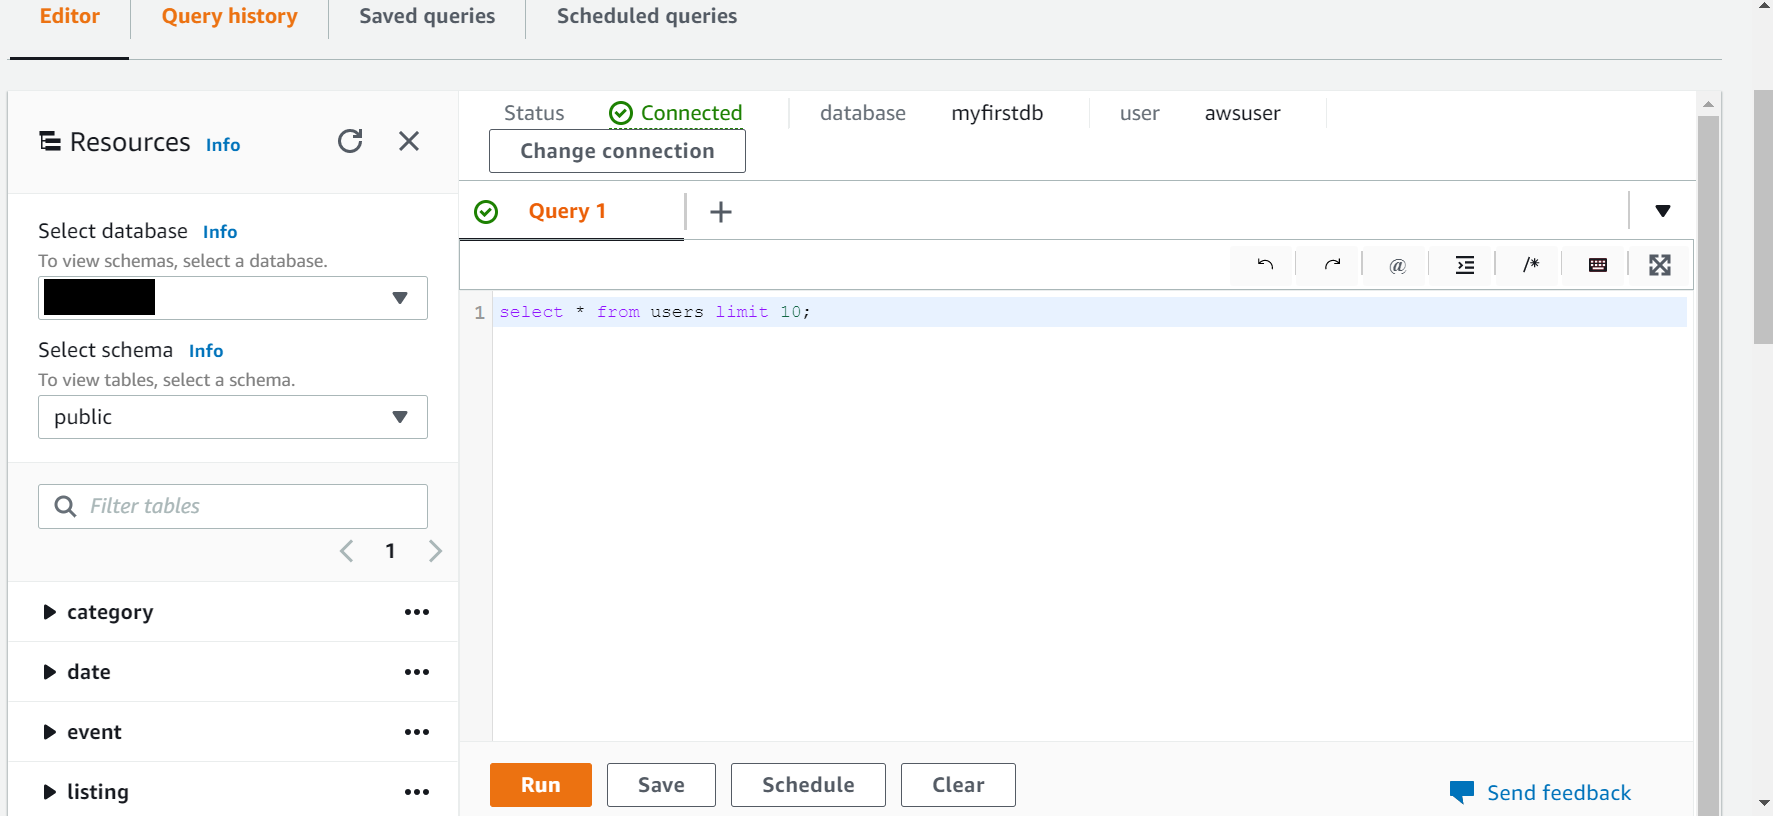

In [139]:
display(Image(filename='images/tables.png'))

In [58]:
# for psycopg errors -
# cur.execute("ROLLBACK")
# conn.commit()

## Loading Data into the tables -
### (Redshift - COPY Command)

In [114]:
try:
    cur.execute("""
    copy users from 's3://abhishek-dev-bucket/allusers_pipe.txt'
    credentials 'aws_iam_role=<***your iam role ARN here***>'
    delimiter '|'
    region 'us-east-2'    
    """)
except psycopg2.Error as e:
    print(e)

In [115]:
try:
    cur.execute("""
    copy venue from 's3://abhishek-dev-bucket/venue_pipe.txt'
    credentials 'aws_iam_role=<***your iam role ARN here***>'
    delimiter '|'
    region 'us-east-2'    
    """)
except psycopg2.Error as e:
    print(e)

In [116]:
try:
    cur.execute("""
    copy category from 's3://abhishek-dev-bucket/category_pipe.txt'
    credentials 'aws_iam_role=<***your iam role ARN here***>'
    delimiter '|'
    region 'us-east-2'    
    """)
except psycopg2.Error as e:
    print(e)

In [117]:
try:
    cur.execute("""
    copy date from 's3://abhishek-dev-bucket/date2008_pipe.txt'
    credentials 'aws_iam_role=<***your iam role ARN here***>'
    delimiter '|'
    region 'us-east-2'    
    """)
except psycopg2.Error as e:
    print(e)

In [118]:
try:
    cur.execute("""
    copy event from 's3://abhishek-dev-bucket/allevents_pipe.txt'
    credentials 'aws_iam_role=<***your iam role ARN here***>'
    delimiter '|'
    region 'us-east-2'    
    """)
except psycopg2.Error as e:
    print(e)

In [119]:
try:
    cur.execute("""
    copy listing from 's3://abhishek-dev-bucket/listings_pipe.txt'
    credentials 'aws_iam_role=<***your iam role ARN here***>'
    delimiter '|'
    region 'us-east-2'    
    """)
except psycopg2.Error as e:
    print(e)

In [120]:
cur.execute("""select * from category;""")
row = cur.fetchone()
while row:
    print(row)
    row = cur.fetchone()

(1, 'Sports', 'MLB', 'Major League Baseball')
(3, 'Sports', 'NFL', 'National Football League')
(6, 'Shows', 'Musicals', 'Musical theatre')
(8, 'Shows', 'Opera', 'All opera and light opera')
(11, 'Concerts', 'Classical', 'All symphony, concerto, and choir concerts')
(2, 'Sports', 'NHL', 'National Hockey League')
(4, 'Sports', 'NBA', 'National Basketball Association')
(5, 'Sports', 'MLS', 'Major League Soccer')
(7, 'Shows', 'Plays', 'All non-musical theatre')
(9, 'Concerts', 'Pop', 'All rock and pop music concerts')
(10, 'Concerts', 'Jazz', 'All jazz singers and bands')


Query results for 'users' as seen on the query editor tool on redshift -

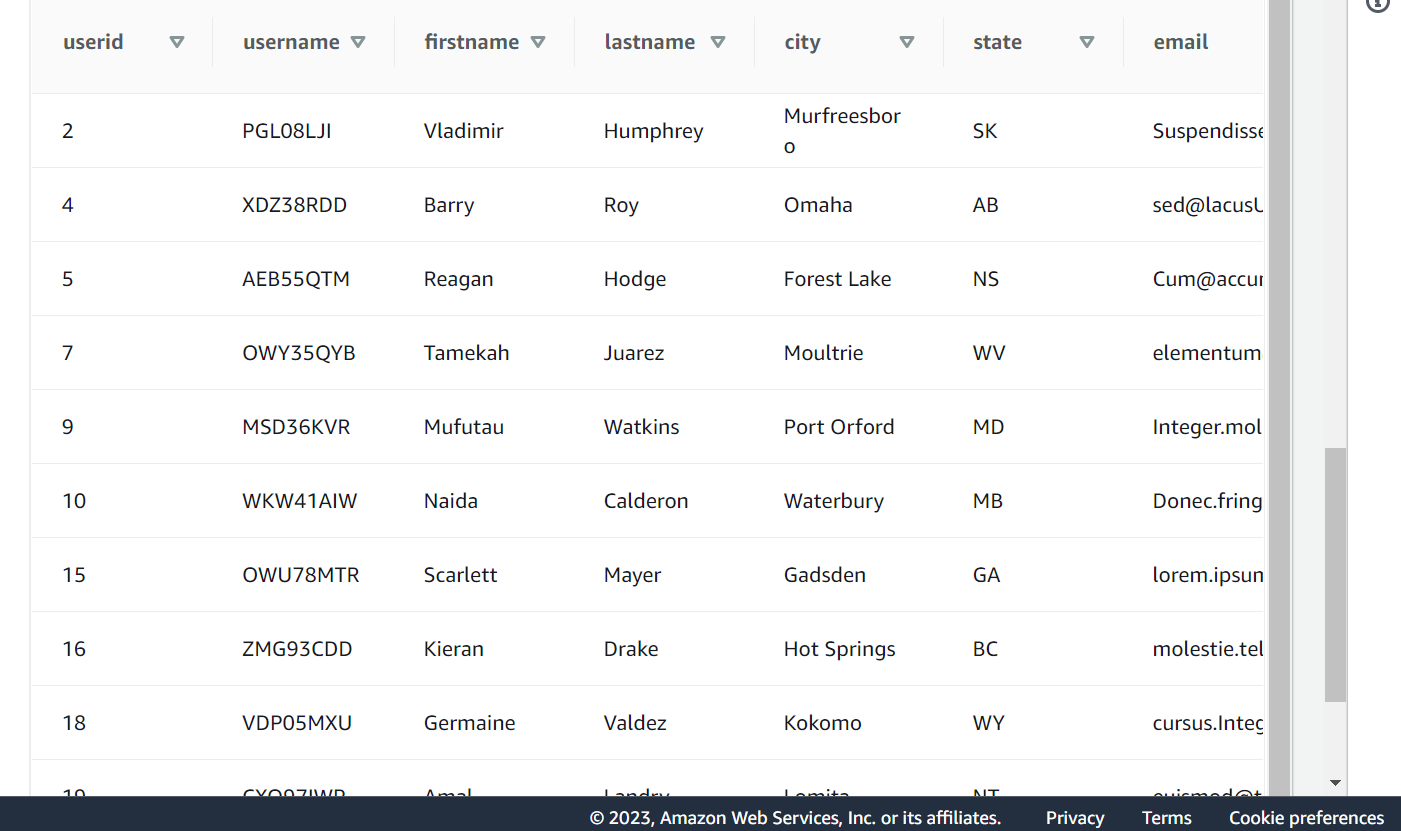

In [140]:
display(Image(filename='images/data.png'))

In [121]:
conn.close()

### Deleting cluster -

In [123]:
# redshift.delete_cluster(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER, SkipFinalClusterSnapshot=True)